# Test case LVV-1183 ([Jira](https://rubinobs.atlassian.net/browse/LVV-1183))

## Specification: 
From OSS-REQ-0337-V-01 - Bright, Isolated Point Source:

The terms "bright, isolated point source" and "isolated point source" are used repeatedly in the data quality requirements. This is because many of the requirements are specified as an asymptotic value in the absence of contributions from photon statistics or overlapping objects/confusion. For the purposes of defining test cases for these requirements, "bright" shall be understood to mean having a magnitude in the "bright end" range as defined in sec. 3.3 of the SRD. "Isolated point source" shall be understood to mean a point source (typically a star) having no other detected source within a radius of isolatedRadius PSF FWHM.

Section 3.3 of the SRD says:
For quantities with a strong dependence on the signal-to-noise ratio (SNR), requirements are specified at the bright end, defined here as the magnitude range between 1 mag and 4 mag fainter than the saturation limit (full well) in a given bandpass.

## Requirement Parameters
- isolatedRadius = 10[unitless] Radius containing no other detected sources

## Discussion 
Since the brightness is defined relative to saturation this selection only makes sense in the source/visit context not object/coadd.

For isolated sources the [isolatedStarAssociationTask](https://github.com/lsst/pipe_tasks/blob/97db14605fce2780f317e52ad9394377b74bb449/python/lsst/pipe/tasks/isolatedStarAssociation.py#L93) and thus FGCM and the repeatability metrics in analysis_tools use a default isolation radius of 2 arcseconds. 

The isolated star association task also makes signal to noise cuts 50 < S/N < 1000, and applies a ['science'](https://github.com/lsst/meas_algorithms/blob/2179890f7669222004f056611957f506a53e8500/python/lsst/meas/algorithms/sourceSelector.py#L597) selection that is configured to throw out blended and resolved sources.  

The default of the [SNSelector](https://github.com/lsst/analysis_tools/blob/f84664828b733855e17f5dc9837fdacafee68075/python/lsst/analysis/tools/actions/vector/selectors.py#L265) 
configurable action is a SN of 500

Various analysis tools use different thresholds, but 200 seems to be common for many analysis tools based on single visits:
    - The [default scatter plot stats action](https://github.com/lsst/analysis_tools/blob/f84664828b733855e17f5dc9837fdacafee68075/python/lsst/analysis/tools/atools/genericProduce.py#L118)
    - For photometric repeatability the [per group S/N threshold](https://github.com/lsst/analysis_tools/blob/f84664828b733855e17f5dc9837fdacafee68075/python/lsst/analysis/tools/atools/photometricRepeatability.py#L103)

### exploring this selection:
To explore this selection we want to see how common are:
- Bright isolated sources (1-4 mag fainter than saturation and no other stars within 10 * psf FWHM)
- Isolated stars selected by the association task (50 < S/N < 1000 and no other stars within 2'')

The high galactic lattitude field ECDFS will at as an upper limit on the number of isolated sources (since it is a low density field). 

In [1]:
import fitsio
import matplotlib.pyplot as plt
import numpy 
import pandas as pd
import lsst.daf.butler as dafButler
import numpy as np
import astropy.units as u
import smatch
from lsst.utils.plotting import (get_multiband_plot_colors, get_multiband_plot_symbols, get_multiband_plot_linestyles)
from lsst.meas.algorithms import ScienceSourceSelectorConfig, ScienceSourceSelectorTask, sourceSelectorRegistry
import logging

# Disable all logging messages
logging.disable(logging.CRITICAL)

In [2]:
bandColorDict = get_multiband_plot_colors()
ra_col = "coord_ra"
dec_col = "coord_dec"
bands = 'ugrizy'

In [3]:
repo = '/repo/main'
collections =["LSSTComCam/runs/DRP/DP1/w_2025_05/DM-48666"]
butler = dafButler.Butler(repo, collections=collections)
tract= 5063
dataId={"tract":5063, 'instrument': 'LSSTComCam', 'skymap': 'lsst_cells_v1'}

In [4]:
ref_presources=sorted(butler.registry.queryDatasets('isolated_star_presources', dataId=dataId))[0]
ref_presource_assoc=sorted(butler.registry.queryDatasets('isolated_star_presource_associations', dataId=dataId))[0]
isolated_star_presources = butler.get(ref_presources)
isolated_star_presource_associations = butler.get(ref_presource_assoc)
visits = list(np.unique(isolated_star_presources['visit']))
ccd_visit_table=butler.get(sorted(butler.registry.queryDatasets('ccdVisitTable', dataId={"visit": visits[0], 'instrument': 'LSSTComCam'}))[0])

In [5]:
# setup science source selector
source_selector_config = ScienceSourceSelectorConfig()

source_selector_config.doFlags = True
source_selector_config.doUnresolved = True
source_selector_config.doSignalToNoise = True
source_selector_config.doIsolated = True
source_selector_config.doRequireFiniteRaDec = True
source_selector_config.doRequirePrimary = True

source_selector_config.signalToNoise.minimum = 50.0
source_selector_config.signalToNoise.maximum = 1000.0

flux_flag_name = "psfFlux_flag"

source_selector_config.flags.bad = ['pixelFlags_edge',
                             'pixelFlags_interpolatedCenter',
                             'pixelFlags_saturatedCenter',
                             'pixelFlags_crCenter',
                             'pixelFlags_bad',
                             'pixelFlags_interpolated',
                             'pixelFlags_saturated',
                             'centroid_flag',
                             flux_flag_name]

source_selector_config.signalToNoise.fluxField = "psfFlux"
source_selector_config.signalToNoise.errField = "psfFlux" + 'Err'

source_selector_config.isolated.parentName = 'parentSourceId'
source_selector_config.isolated.nChildName = 'deblend_nChild'

source_selector_config.unresolved.name = 'sizeExtendedness'
source_selector = ScienceSourceSelectorTask(config =source_selector_config)

In [6]:
# For each isolated source we want to find the nearest neighbor in the preSourceTable (including everything besides skySources). 
visit_cats =[]
for visit in visits:
    # given a visit load in preSource table
    ref_preSource = sorted(butler.registry.queryDatasets('preSourceTable_visit', dataId={"visit": visit, 'instrument': 'LSSTComCam'}))[0]
    preSourceCatalog = butler.get(ref_preSource)
    preSourceCatalog['source_flag']= source_selector.selectSources(preSourceCatalog).selected
    # get the isolated star presources from table
    subcat =  isolated_star_presources.loc[isolated_star_presources["visit"]==visit, :].copy()
    subcat["psfSigma"] = 0.0
    for detector in np.unique(subcat["detector"]):
        psf_sigma=ccd_visit_table.loc[(ccd_visit_table["visitId"]==visit) & (ccd_visit_table["detector"]==detector), "psfSigma"].values[0]
        subcat.loc[subcat['detector']==detector, 'psfSigma']=psf_sigma
    # remove isolated star presources from the preSourcecatalog
    sel_src=np.ones(len(preSourceCatalog))
    sel_src[subcat["source_row"].values]=0
    sel_src[preSourceCatalog["sky_source"] == False] =0
    sel_src=sel_src.astype(bool)
    # matchy isolated catalog to preSource with the isolated sources removed
    result=smatch.match(subcat["ra"], subcat["dec"], 300/3600, preSourceCatalog.loc[sel_src,ra_col], preSourceCatalog.loc[sel_src,dec_col], maxmatch=1)
    
    dist = np.rad2deg(np.arccos(result['cosdist'])) * 3600
    
    subcat["dist"]=dist
    subcat["psfFlux"] = preSourceCatalog['psfFlux'].values[subcat["source_row"].values]
    subcat["psfFluxErr"] = preSourceCatalog['psfFluxErr'].values[subcat["source_row"].values]
    subcat['source_flag'] = preSourceCatalog['source_flag'].values[subcat["source_row"].values]
    visit_cats.append(subcat)
visit_cat = pd.concat(visit_cats)

In [7]:
visit_cat['psfMag'] = (visit_cat['psfFlux'].values * u.nJy).to(u.ABmag).value
visit_cat['s2n'] = visit_cat['psfFlux']/ visit_cat['psfFluxErr']

Text(0.5, 1, 'Number of Bright Isolated Sources (BIS) in 896 visits of tract: 5063')

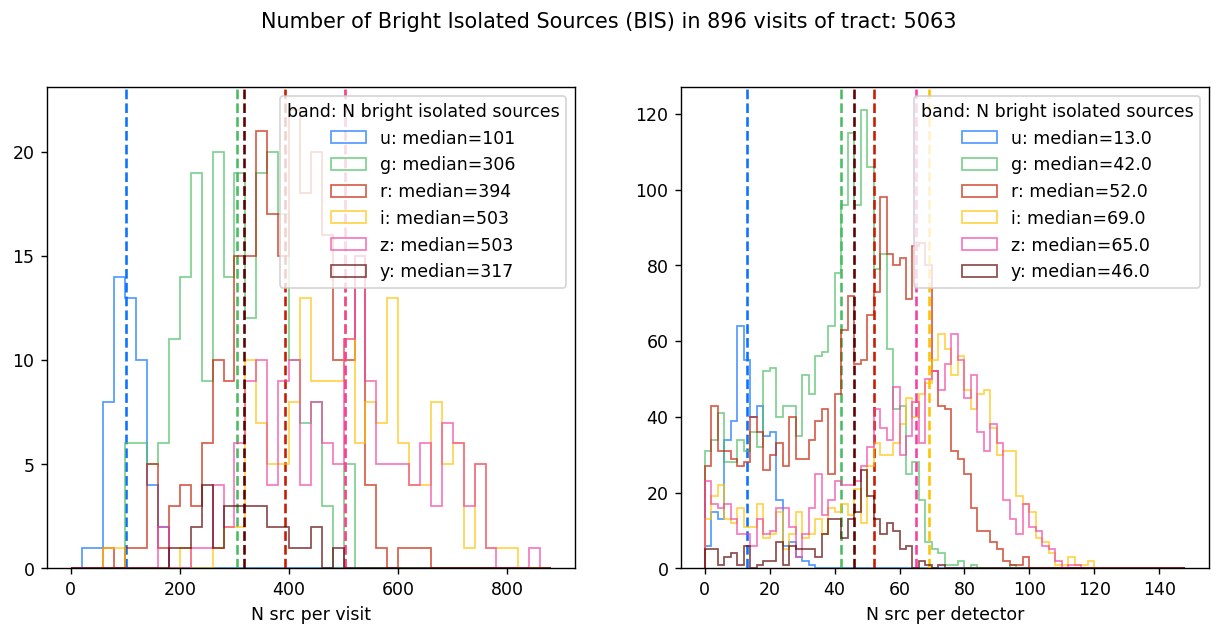

In [8]:
# what requirements are saying a bright isolated source should be 
fig, axs = plt.subplots(1,2, figsize = (12,5), dpi=125)
for band in bands:
    sel = (visit_cat['band'] == band) & ((visit_cat['dist']/visit_cat["psfSigma"]) >=10) & (visit_cat['source_flag']==1)
    size = visit_cat[sel].groupby('visit').size()
    ax = axs[0]
    ax.hist(size, bins=np.arange(0,900,20), label=f"{band}: median={np.median(size):0.0f}", color = bandColorDict[band], alpha=0.7, histtype="step")
    ax.axvline(np.median(size), color=bandColorDict[band], ls="dashed")
ax.legend(title="band: N bright isolated sources")
axs[0].set(xlabel="N src per visit")

for band in bands:
    sel = (visit_cat['band'] == band) & ((visit_cat['dist']/visit_cat["psfSigma"]) >=10) & (visit_cat['source_flag']==1)
    size = visit_cat[sel].groupby(['visit','detector']).size().values
    ax = axs[1]
    ax.hist(size, bins=np.arange(0,150,2), label=f"{band}: median={np.median(size):0.1f}", color = bandColorDict[band], alpha=0.7, histtype="step")
    ax.axvline(np.median(size), color=bandColorDict[band], ls="dashed")
plt.legend(title="band: N bright isolated sources")
axs[1].set(xlabel="N src per detector")
plt.suptitle(f"Number of Bright Isolated Sources (BIS) in {len(visits)} visits of tract: {5063}",#\nA BIS is defined as < 4 mags fainter than saturation\n and no detected sources withing 10 * PSF FWHM",
             y=1)

## Currently in the science pipelines we are either using the 'detect_is_isolated' flag or stating that a source is not within 2'' of another science source


Text(0.5, 1, "Number of Bright Sources in 896 visits of tract: 5063\n and no detected sources withing 2''")

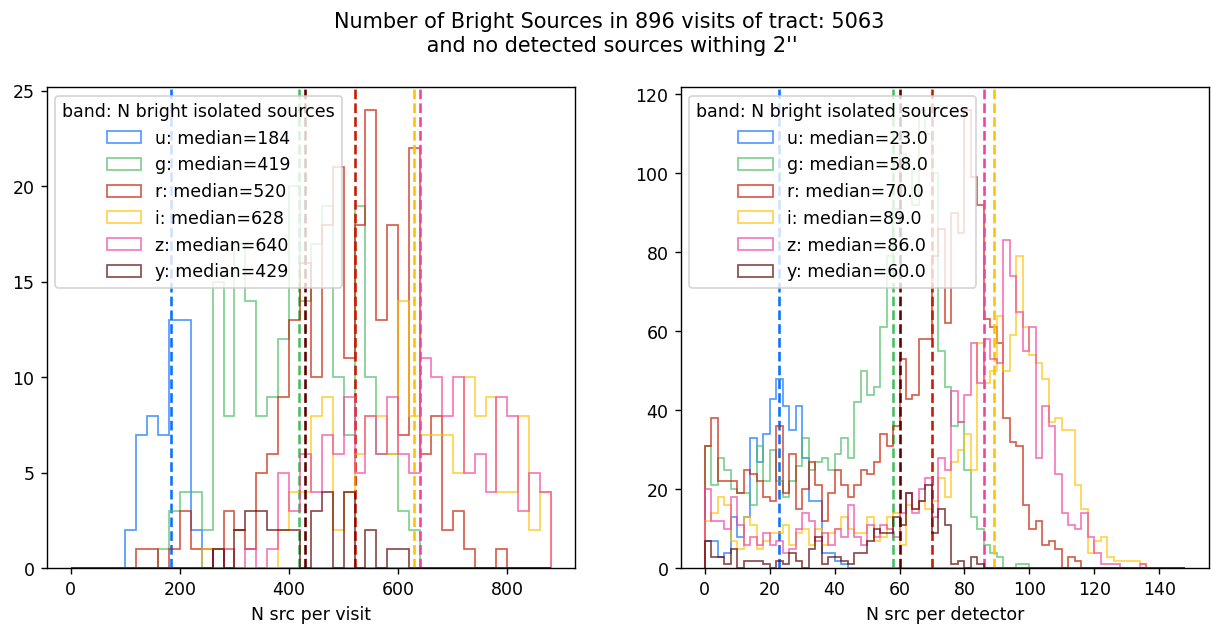

In [9]:
# what we are currently doing
fig, axs = plt.subplots(1,2, figsize = (12,5), dpi=125)
for band in bands:
    sel = (visit_cat['band'] == band) & (visit_cat['source_flag']==1)
    size = visit_cat[sel].groupby('visit').size()
    ax = axs[0]
    ax.hist(size, bins=np.arange(0,900,20), label=f"{band}: median={np.median(size):0.0f}", color = bandColorDict[band], alpha=0.7, histtype="step")
    ax.axvline(np.median(size), color=bandColorDict[band], ls="dashed")
ax.legend(title="band: N bright isolated sources")
axs[0].set(xlabel="N src per visit")

for band in bands:
    sel = (visit_cat['band'] == band) & (visit_cat['source_flag']==1)
    size = visit_cat[sel].groupby(['visit','detector']).size().values
    ax = axs[1]
    ax.hist(size, bins=np.arange(0,150,2), label=f"{band}: median={np.median(size):0.1f}", color = bandColorDict[band], alpha=0.7, histtype="step")
    ax.axvline(np.median(size), color=bandColorDict[band], ls="dashed")
plt.legend(title="band: N bright isolated sources")
axs[1].set(xlabel="N src per detector")
plt.suptitle(f"Number of Bright Sources in {len(visits)} visits of tract: {5063}\n and no detected sources withing 2''",
             y=1)

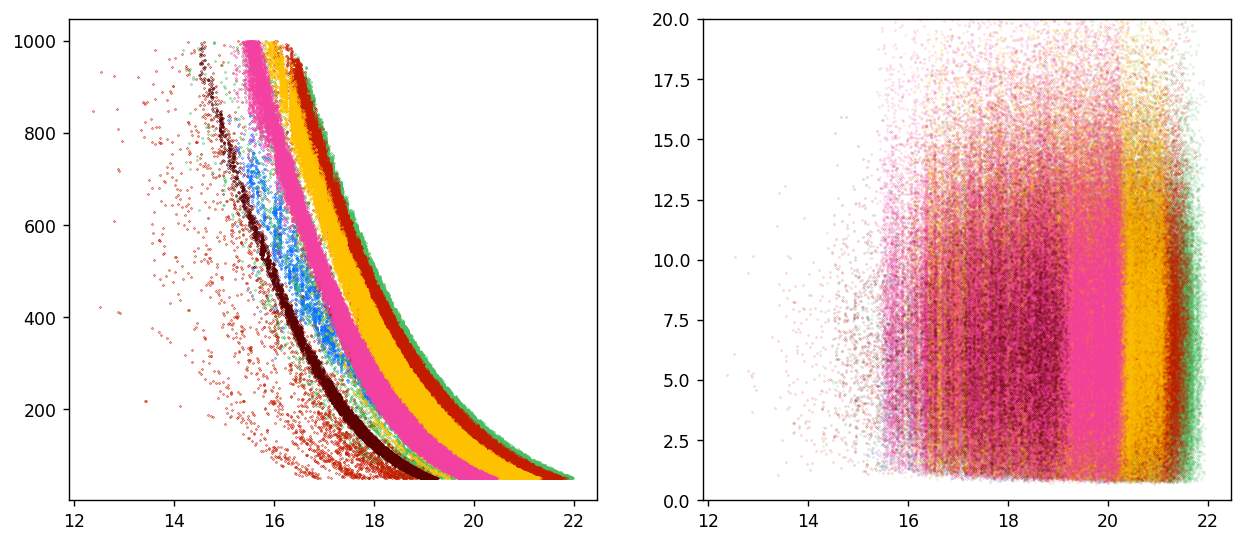

In [10]:
fig, axs = plt.subplots(1,2, figsize = (12,5), dpi=125)
for band in bands:
    sel = (visit_cat['band'] == band) & (visit_cat['source_flag']==1)
    ax=axs[0]
    ax.scatter(visit_cat['psfMag'][sel], visit_cat['s2n'][sel], color=bandColorDict[band], s=0.1)

    ax=axs[1]
    ax.scatter(visit_cat['psfMag'][sel], (visit_cat['dist']/visit_cat['psfSigma']/2.35)[sel], color=bandColorDict[band], s=0.1, alpha=0.3)
    ax.set_ylim(0,20)

9453 540 5593
94941 1735 69405
125181 2263 95024
109134 2397 86448
105231 2174 82743
12768 1229 9722


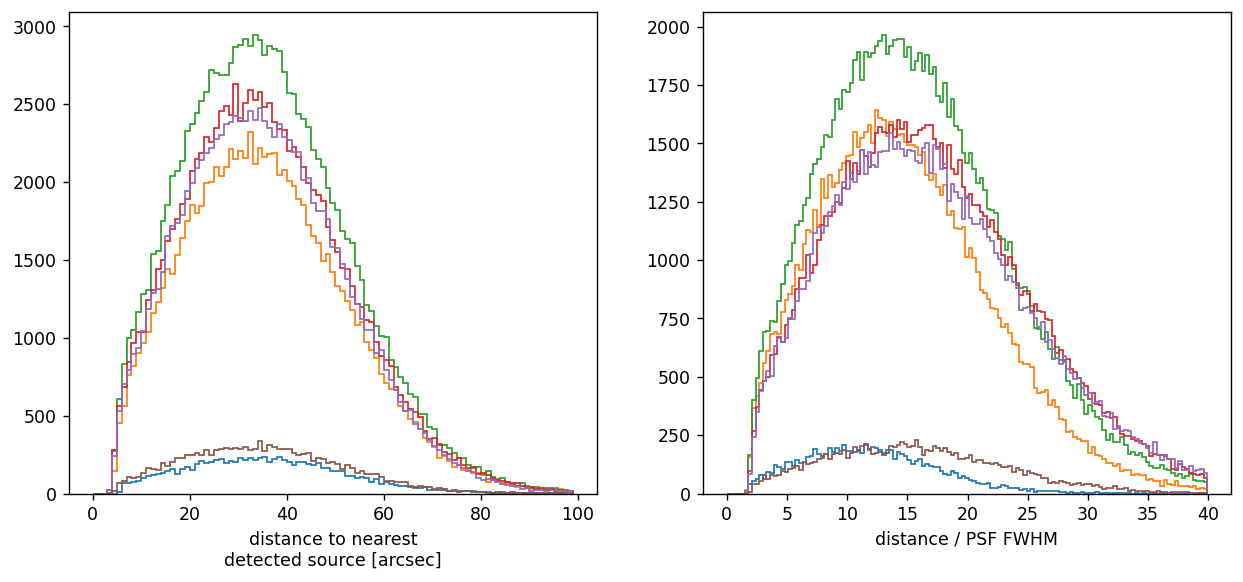

In [11]:
fig, axs = plt.subplots(1,2, figsize = (12,5), dpi=125)
for band in bands:
    sel = (visit_cat['band'] == band) & (visit_cat['source_flag']==1)
    ax=axs[0]
    ax.hist(visit_cat['dist'][sel], bins=np.arange(0,100,1), histtype="step", label=band)
    ax.set_xlabel('distance to nearest\ndetected source [arcsec]')
    ax = axs[1]
    ax.hist((visit_cat['dist']/visit_cat["psfSigma"])[sel], bins=np.arange(0,40,0.3),
            histtype="step", label=band)#, density=True)
    
    ax.set(xlabel='distance / PSF FWHM')
    print(sel.sum(), len(np.unique(visit_cat['obj_index'][sel].values)), sum(sel & ((visit_cat['dist']/visit_cat["psfSigma"])[sel] > 10)))
    